In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc, select as sel


In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")
Base = automap_base()

In [5]:
# reflect an existing database into a new model
# reflect the tables
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(most_recent_date)

2017-08-23


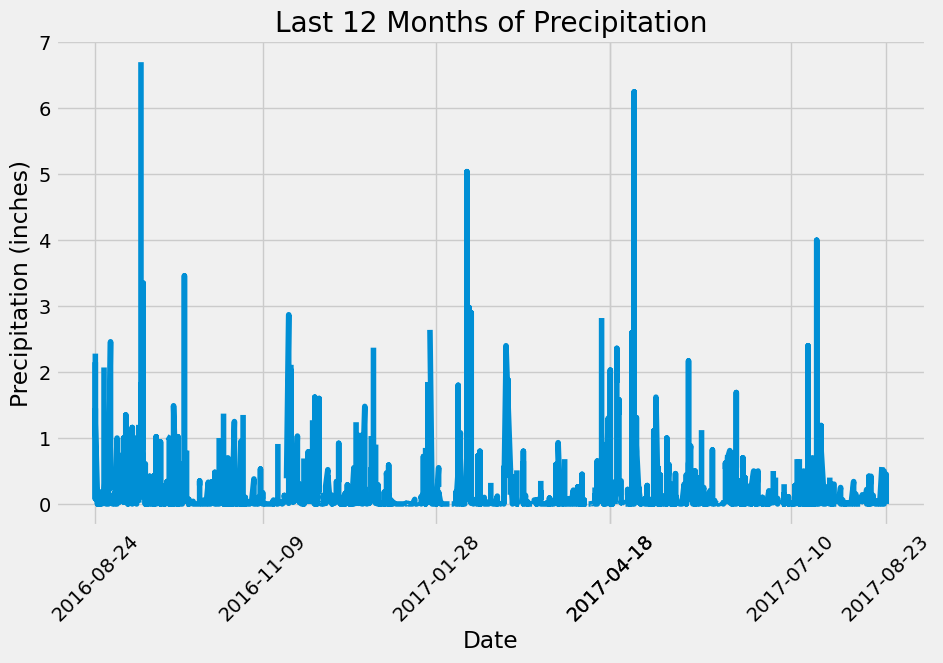

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = session.query(func.max(Measurement.date)).scalar()
last_date = dt.datetime.strptime(last_date, "%Y-%m-%d")
one_year_ago = last_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(desc(Measurement.date))
results = query.all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
df.sort_values('date', inplace=True)


# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['precipitation'])
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Last 12 Months of Precipitation')
min_date = df['date'].min()
max_date = df['date'].max()
xticks = [min_date, '2016-11-09', '2017-01-28','2017-04-18','2017-04-18','2017-07-10',max_date]
plt.xticks(xticks, rotation=45)

plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = pd.DataFrame(df['precipitation'].describe())
summary_stats

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
stationcount= session.query(Station.station).count() 
stationcount


9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
mostactive = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').first()
print(f'min:{mostactive[0]}, max:{mostactive[1]}, average:{mostactive[2]}')

min:54.0, max:85.0, average:71.66378066378067


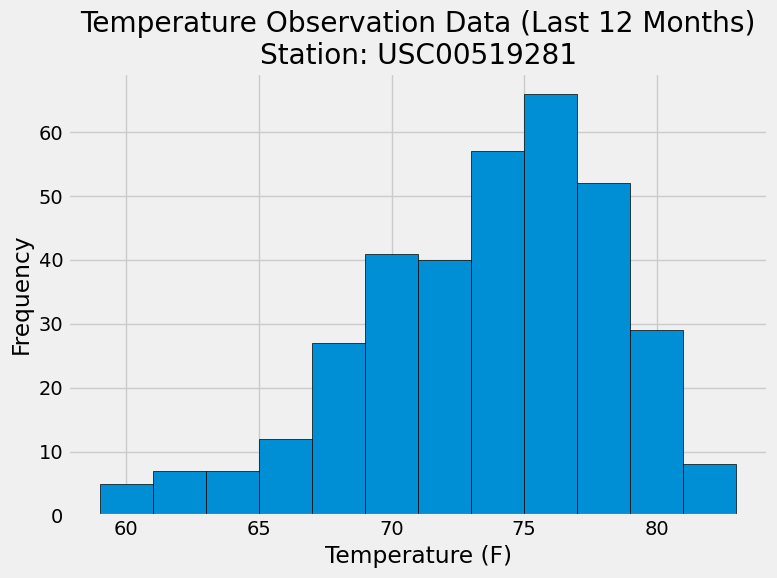

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

df = pd.DataFrame(results, columns=['date', 'temperature'])

plt.figure(figsize=(8, 6))
plt.hist(df['temperature'], bins=12, edgecolor='black')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data (Last 12 Months)\nStation: USC00519281')
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()